# Machine Learning: FACEIT Match Outcome Prediction

In this part, I use machine learning to predict CS2 match outcomes from my FACEIT performance stats.

### Goal
I want to test **three hypotheses**:

1. **H1: Entry win rate is positively associated with winning the match**
   Test whether **entry win rate** is positively associated with winning matches. I predict **win/loss** outcomes using Logistic Regression based on entry performance metrics and traditional statistics.

2. **H2: A more positive first_kills - first_deaths balance is associated with a larger round_difference**
   Test whether **first kill/death difference (fk_fd_diff)** is positively associated with **round difference**. I predict the match margin (round difference) as a continuous variable using both **Linear Regression** and **Random Forest Regression** to compare linear and non-linear modeling approaches.

3. **H3: Entry-related signals add predictive value beyond KD when basic controls are included**
   Test whether **entry-related features add predictive value** beyond traditional metrics (KD, ADR, KR). I compare a Base Model (traditional metrics only) against a Full Model (traditional + entry features) to measure improvement.

---

### Dataset Overview

The dataset contains **484 competitive CS2 matches** from personal FACEIT account:

**Core Statistics:**
- **Performance Metrics**: kills, deaths, assists, headshots, KD ratio, ADR (average damage per round), KR (kills per round), MVPs
- **Entry Statistics**: first_kills, first_deaths, entry_count, entry_wins
- **Match Information**: map, result (Win/Loss), rounds_played, overtime status, match duration
- **Score Details**: my_team_score, enemy_team_score, round_difference

**Time Period**: June 2025 - November 2025
**Win Rate**: 50.6% (245 Wins, 239 Losses) - balanced wins and losses

---

### Feature Engineering Plan

To prepare the dataset for machine learning, I will:

**Derived Features:**
- **`entry_rate`** = entry_count / rounds_played
  Measures how often you take first engagements (quantity)

- **`entry_win_rate`** = entry_wins / entry_count
  Measures success rate in first engagements (quality)
  *Note: Used average value for 5 matches with zero entry attempts*

- **`fk_fd_diff`** = first_kills - first_deaths
  Shows if you get more first kills than first deaths

- **`win`** = 1 if result == "Win", else 0
  Binary target variable for classification

**Data Preparation:**
- Drop rows with missing values
- Standardize numerical features (for Linear/Logistic Regression)
- No scaling needed for tree-based models
- Train/test split (80/20) with stratification for classification

---

### Model Plan

I will train and evaluate the following models:

**For H1 (Win/Loss Prediction - Binary Classification):**
- **Logistic Regression**
  Linear model for binary classification with probability outputs

**For H2 (Round Difference Prediction - Regression):**
- **Linear Regression**
  Predicts continuous round difference using performance metrics (linear relationships)
- **Random Forest Regression**
  Predicts continuous round difference using ensemble of decision trees (captures non-linear relationships and feature interactions)

**For H3 (Model Comparison):**
- **Base Model**: Logistic Regression with KD + ADR + KR only
- **Full Model**: Logistic Regression with KD + ADR + KR + Entry Features
- Compare performance to assess added value of entry features

**Evaluation Metrics:**

*Classification (H1, H3):*
- Accuracy
- Precision, Recall, F1-Score
- ROC-AUC Score
- Confusion Matrix
- ROC Curve

*Regression (H2):*
- R² Score (how well the model explains the data)
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Actual vs Predicted scatter plots
- Feature coefficients/importance

---

### Main Question

Do **entry duels** (the first fights in a round) predict winning better than just looking at KD?

- **Common belief**: KD ratio is the main performance indicator
- **My hypothesis**: Entry duels that create 5v4 advantages might matter more than late-round kills

If true, **entry win rate** would show a skill that KD alone can't measure.

## 1. Setup: Install Libraries

In [27]:
%pip install pandas numpy matplotlib seaborn scikit-learn -q

print("Libraries installation complete")

Note: you may need to restart the kernel to use updated packages.
Libraries installation complete


## 2. Import Libraries

In [28]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(42)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 3. Load and Prepare Dataset

I load the FACEIT match statistics and perform feature engineering to create derived metrics needed for hypothesis testing.

In [29]:
# Load the dataset
df = pd.read_csv("my_faceit_matches.csv")

print(f"Dataset loaded: {df.shape[0]} matches, {df.shape[1]} features")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

Dataset loaded: 484 matches, 22 features

Date range: 2025-06-19 02:56:26 to 2025-11-07 14:31:41

Column names:
  - date
  - map
  - result
  - kills
  - deaths
  - assists
  - hs
  - hs_percent
  - kd
  - kr
  - mvps
  - adr
  - first_kills
  - first_deaths
  - entry_count
  - entry_wins
  - rounds_played
  - overtime
  - match_duration_min
  - my_team_score
  - enemy_team_score
  - round_difference


## 4. Feature Engineering

Create derived features for hypothesis testing:

- **entry_rate**: Frequency of taking entry duels (entry_count / rounds_played)
- **entry_win_rate**: Success rate in entry duels (entry_wins / entry_count)
- **fk_fd_diff**: Net first engagement performance (first_kills - first_deaths)
- **win**: Binary target (1 for Win, 0 for Loss)

**Note on Missing Values:**
For matches where `entry_count = 0` (no entry attempts), `entry_win_rate` is imputed with the mean value to avoid division by zero.

In [30]:
# Parse date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Feature Engineering
# 1. entry_rate = entry_count / rounds_played
df['entry_rate'] = df['entry_count'] / df['rounds_played']

# 2. entry_win_rate = entry_wins / entry_count (with mean imputation for zero entries)
df['entry_win_rate'] = df.apply(
    lambda row: row['entry_wins'] / row['entry_count'] if row['entry_count'] > 0 else np.nan,
    axis=1
)
mean_entry_win_rate = df['entry_win_rate'].mean()
n_imputed = df['entry_win_rate'].isna().sum()
df['entry_win_rate'] = df['entry_win_rate'].fillna(mean_entry_win_rate)

# 3. fk_fd_diff = first_kills - first_deaths
df['fk_fd_diff'] = df['first_kills'] - df['first_deaths']

# 4. win = 1 if Win, 0 if Loss
df['win'] = (df['result'].str.strip().str.title() == 'Win').astype(int)

print("✓ Feature engineering complete")
print(f"\nDerived Features Created:")
print(f"  - entry_rate: min={df['entry_rate'].min():.3f}, max={df['entry_rate'].max():.3f}, mean={df['entry_rate'].mean():.3f}")
print(f"  - entry_win_rate: min={df['entry_win_rate'].min():.3f}, max={df['entry_win_rate'].max():.3f}, mean={df['entry_win_rate'].mean():.3f}")
print(f"  - fk_fd_diff: min={df['fk_fd_diff'].min():.0f}, max={df['fk_fd_diff'].max():.0f}, mean={df['fk_fd_diff'].mean():.2f}")
print(f"  - win: {df['win'].sum()} wins ({df['win'].mean()*100:.1f}%), {(1-df['win']).sum()} losses ({(1-df['win'].mean())*100:.1f}%)")
print(f"\nNote: Imputed {n_imputed} missing entry_win_rate values with mean ({mean_entry_win_rate:.4f})")

✓ Feature engineering complete

Derived Features Created:
  - entry_rate: min=0.000, max=0.619, mean=0.219
  - entry_win_rate: min=0.000, max=1.000, mean=0.497
  - fk_fd_diff: min=-6, max=7, mean=0.08
  - win: 245 wins (50.6%), 239 losses (49.4%)

Note: Imputed 5 missing entry_win_rate values with mean (0.4970)


## 5. Data Quality Check

Verify data integrity and check for missing values before modeling.

In [31]:
# Check for missing values
print("Missing Values Summary:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("  ✓ No missing values found")
else:
    print(missing[missing > 0].sort_values(ascending=False))

# Summary statistics for key features
print("\n" + "="*70)
print("Summary Statistics - Key Features")
print("="*70)
key_features = ['kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'fk_fd_diff', 'round_difference']
print(df[key_features].describe())

# Win rate by map
print("\n" + "="*70)
print("Win Rate by Map")
print("="*70)
map_stats = df.groupby('map').agg({
    'win': ['mean', 'count']
}).round(3)
map_stats.columns = ['Win_Rate', 'Matches']
map_stats = map_stats.sort_values('Win_Rate', ascending=False)
print(map_stats)

Missing Values Summary:
  ✓ No missing values found

Summary Statistics - Key Features
               kd         adr          kr  entry_rate  entry_win_rate  \
count  484.000000  484.000000  484.000000  484.000000      484.000000   
mean     1.107087   83.513636    0.747417    0.219126        0.496954   
std      0.516693   20.496213    0.229518    0.105626        0.261874   
min      0.060000   20.700000    0.060000    0.000000        0.000000   
25%      0.777500   69.400000    0.590000    0.142857        0.333333   
50%      1.000000   81.900000    0.730000    0.210526        0.500000   
75%      1.330000   95.300000    0.870000    0.277778        0.666667   
max      6.000000  163.600000    1.780000    0.619048        1.000000   

       fk_fd_diff  round_difference  
count  484.000000        484.000000  
mean     0.080579          0.526860  
std      2.232759          5.565468  
min     -6.000000        -13.000000  
25%     -1.000000         -4.000000  
50%      0.000000          

## 6. Data Preview

Quick look at the dataset structure and sample records.

In [32]:
# Display first few rows
print("First 5 matches:")
print(df[['date', 'map', 'result', 'kd', 'adr', 'entry_win_rate', 'fk_fd_diff', 'round_difference']].head())

# Display random sample
print("\n\nRandom sample of 3 matches:")
print(df[['date', 'map', 'result', 'kd', 'adr', 'entry_win_rate', 'fk_fd_diff', 'round_difference']].sample(3))

First 5 matches:
                 date        map result    kd   adr  entry_win_rate  \
0 2025-11-07 14:31:41  de_mirage   Loss  0.19  47.9        0.250000   
1 2025-11-07 12:15:46   de_dust2   Loss  1.00  98.6        0.400000   
2 2025-11-07 11:43:51   de_train   Loss  0.60  76.3        0.000000   
3 2025-11-06 21:31:54  de_mirage   Loss  0.83  69.2        0.285714   
4 2025-11-06 18:40:52   de_dust2    Win  1.25  97.4        1.000000   

   fk_fd_diff  round_difference  
0          -4                 5  
1          -1                 4  
2          -2                 7  
3          -3                 2  
4           4                -3  


Random sample of 3 matches:
                   date        map result    kd   adr  entry_win_rate  \
418 2025-07-12 02:06:01   de_dust2   Loss  1.12  92.9        0.333333   
474 2025-06-21 19:21:28  de_mirage    Win  2.62  94.2        0.000000   
181 2025-09-14 04:15:58   de_dust2    Win  0.67  74.2        0.666667   

     fk_fd_diff  round_differ

---

# HYPOTHESIS TESTING WITH MACHINE LEARNING

---

## H2: A more positive first_kills - first_deaths balance is associated with a larger round_difference

**Question:**
Does a better first kill vs first death balance lead to bigger win margins?

**Approach:**
I use both **Linear Regression** and **Random Forest Regression** to predict `round_difference` as a continuous variable using performance metrics. This allows comparison between linear and non-linear modeling approaches:
- **Target**: round_difference (my_team_score - enemy_team_score)
- **Features**: fk_fd_diff, kd, adr, kr, entry_rate, entry_win_rate, first_kills, first_deaths
- **Models**: 
  - Linear Regression (captures linear relationships)
  - Random Forest Regression (captures non-linear relationships and feature interactions)

**What I Expect:**
If H2 is correct, `fk_fd_diff` should have a positive effect in both models, and the models should predict round margins well. Random Forest might work better if the relationship isn't a straight line.

In [33]:
# H2: Prepare data
h2_features = ['fk_fd_diff', 'kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']
h2_target = 'round_difference'

# Create clean dataset
h2_data = df[h2_features + [h2_target]].dropna()
X_h2 = h2_data[h2_features]
y_h2 = h2_data[h2_target]

print("="*70)
print("H2: Linear Regression Setup")
print("="*70)
print(f"Dataset: {X_h2.shape[0]} matches")
print(f"Features ({len(h2_features)}): {h2_features}")
print(f"Target: {h2_target}")
print(f"\nTarget distribution:")
print(f"  Mean: {y_h2.mean():.2f}")
print(f"  Std: {y_h2.std():.2f}")
print(f"  Min: {y_h2.min():.0f}, Max: {y_h2.max():.0f}")

H2: Linear Regression Setup
Dataset: 484 matches
Features (8): ['fk_fd_diff', 'kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']
Target: round_difference

Target distribution:
  Mean: 0.53
  Std: 5.57
  Min: -13, Max: 13


In [34]:
# Train/test split
X_h2_train, X_h2_test, y_h2_train, y_h2_test = train_test_split(
    X_h2, y_h2, test_size=0.2, random_state=42
)

# Standardize features (important for Linear Regression)
scaler_h2 = StandardScaler()
X_h2_train_scaled = scaler_h2.fit_transform(X_h2_train)
X_h2_test_scaled = scaler_h2.transform(X_h2_test)

print(f"Train set: {len(X_h2_train)} matches ({len(X_h2_train)/len(X_h2)*100:.0f}%)")
print(f"Test set: {len(X_h2_test)} matches ({len(X_h2_test)/len(X_h2)*100:.0f}%)")
print("\n Features standardized (zero mean, unit variance)")

Train set: 387 matches (80%)
Test set: 97 matches (20%)

 Features standardized (zero mean, unit variance)


In [35]:
# Train Linear Regression model
lr_h2 = LinearRegression()
lr_h2.fit(X_h2_train_scaled, y_h2_train)

# Make predictions
y_h2_pred_train = lr_h2.predict(X_h2_train_scaled)
y_h2_pred_test = lr_h2.predict(X_h2_test_scaled)

print(" Linear Regression model trained")
print(f"  Model intercept: {lr_h2.intercept_:.4f}")

 Linear Regression model trained
  Model intercept: 0.6253


In [36]:
# Evaluate model performance
print("="*70)
print("H2: Linear Regression - Performance Evaluation")
print("="*70)

print("\n TRAIN SET:")
print(f"  R² Score: {r2_score(y_h2_train, y_h2_pred_train):.4f}")
print(f"  MAE: {mean_absolute_error(y_h2_train, y_h2_pred_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_h2_train, y_h2_pred_train)):.4f}")

print("\n TEST SET:")
print(f"  R² Score: {r2_score(y_h2_test, y_h2_pred_test):.4f}")
print(f"  MAE: {mean_absolute_error(y_h2_test, y_h2_pred_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_h2_test, y_h2_pred_test)):.4f}")

# Feature coefficients (standardized)
print("\n FEATURE COEFFICIENTS (Standardized):")
print("  Higher absolute values mean stronger effect on predictions")
coef_df = pd.DataFrame({
    'Feature': h2_features,
    'Coefficient': lr_h2.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))

# Interpretation
print("\n INTERPRETATION:")
test_r2 = r2_score(y_h2_test, y_h2_pred_test)
fk_fd_coef = coef_df[coef_df['Feature'] == 'fk_fd_diff']['Coefficient'].values[0]
if test_r2 < 0:
    print(f"   Model FAILS: Negative R² ({test_r2:.4f}) means worse than baseline")
    print(f"  → H2 NOT SUPPORTED: Model cannot predict round_difference reliably")
    if abs(fk_fd_coef) > 0.1:
        print(f"  → fk_fd_diff has coefficient {fk_fd_coef:.4f}, but overall model fails")
elif test_r2 < 0.1:
    print(f"   Model performs poorly: R² = {test_r2:.4f} (< 0.1)")
    print(f"  → H2 WEAKLY SUPPORTED: Very limited effect on predictions")
    if abs(fk_fd_coef) > 0.1:
        print(f"  → fk_fd_diff coefficient ({fk_fd_coef:.4f}) is notable but model is weak")
else:
    if abs(fk_fd_coef) > 0.1:
        print(f"  ✓ fk_fd_diff shows notable coefficient ({fk_fd_coef:.4f}) - supports H2")
    else:
        print(f"  ✗ fk_fd_diff coefficient is weak ({fk_fd_coef:.4f}) - questions H2")

H2: Linear Regression - Performance Evaluation

 TRAIN SET:
  R² Score: 0.0236
  MAE: 4.6658
  RMSE: 5.3406

 TEST SET:
  R² Score: -0.0085
  MAE: 5.3480
  RMSE: 6.1495

 FEATURE COEFFICIENTS (Standardized):
  Higher absolute values mean stronger effect on predictions
       Feature  Coefficient
            kd     1.371813
            kr    -1.184121
    entry_rate     0.704582
  first_deaths    -0.652332
entry_win_rate    -0.443395
    fk_fd_diff     0.350523
           adr    -0.202101
   first_kills    -0.161748

 INTERPRETATION:
   Model FAILS: Negative R² (-0.0085) means worse than baseline
  → H2 NOT SUPPORTED: Model cannot predict round_difference reliably
  → fk_fd_diff has coefficient 0.3505, but overall model fails


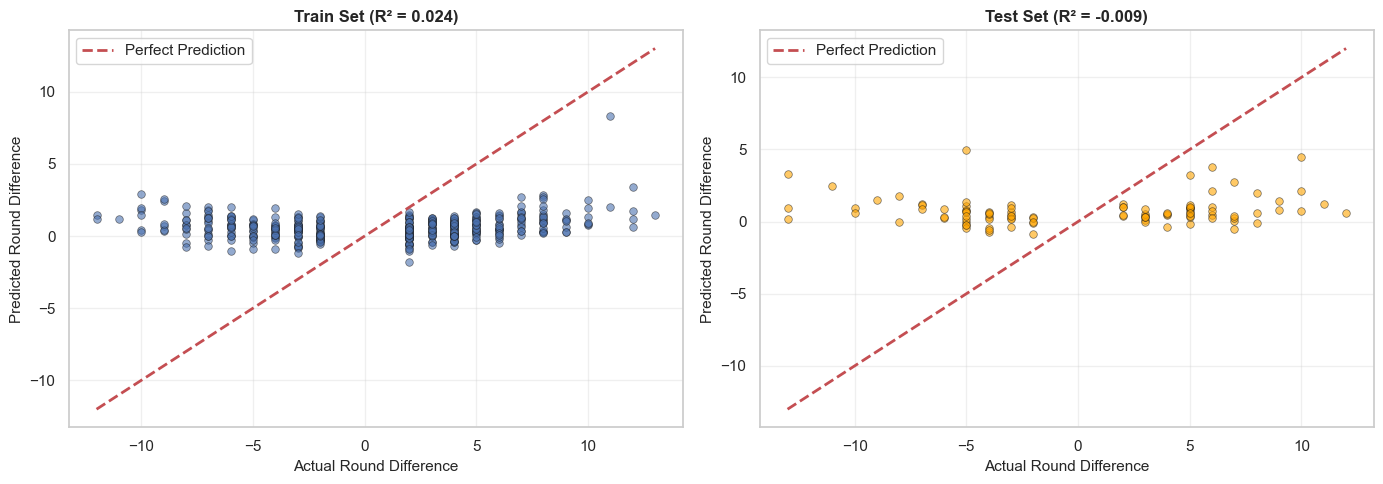

Scatter plots show correlation between actual and predicted values
Points closer to red line indicate better predictions


In [37]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_h2_train, y_h2_pred_train, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[0].plot([y_h2_train.min(), y_h2_train.max()],
             [y_h2_train.min(), y_h2_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Round Difference', fontsize=11)
axes[0].set_ylabel('Predicted Round Difference', fontsize=11)
axes[0].set_title(f'Train Set (R² = {r2_score(y_h2_train, y_h2_pred_train):.3f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_h2_test, y_h2_pred_test, alpha=0.6, s=30, color='orange', edgecolors='k', linewidth=0.5)
axes[1].plot([y_h2_test.min(), y_h2_test.max()],
             [y_h2_test.min(), y_h2_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Round Difference', fontsize=11)
axes[1].set_ylabel('Predicted Round Difference', fontsize=11)
axes[1].set_title(f'Test Set (R² = {r2_score(y_h2_test, y_h2_pred_test):.3f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Scatter plots show correlation between actual and predicted values")
print("Points closer to red line indicate better predictions")

## H2: Random Forest Regression

**Approach:**
I train a Random Forest Regressor as the second model for H2 to compare with Linear Regression. Random Forest can capture non-linear relationships and feature interactions, which may improve prediction performance for round difference.

**Why Random Forest:**
- Can model non-linear relationships between features
- Handles feature interactions automatically
- Less sensitive to outliers than Linear Regression
- Provides feature importance scores
- Allows comparison of linear vs non-linear modeling approaches


In [38]:
# H2: Train Random Forest Regressor
# Note: Random Forest doesn't require feature scaling
rf_h2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_h2.fit(X_h2_train, y_h2_train)

# Make predictions (no scaling needed for Random Forest)
y_h2_pred_rf_train = rf_h2.predict(X_h2_train)
y_h2_pred_rf_test = rf_h2.predict(X_h2_test)

print("="*70)
print("H2: Random Forest Regression - Performance Evaluation")
print("="*70)

print("\n TRAIN SET:")
print(f"  R² Score: {r2_score(y_h2_train, y_h2_pred_rf_train):.4f}")
print(f"  MAE: {mean_absolute_error(y_h2_train, y_h2_pred_rf_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_h2_train, y_h2_pred_rf_train)):.4f}")

print("\n TEST SET:")
print(f"  R² Score: {r2_score(y_h2_test, y_h2_pred_rf_test):.4f}")
print(f"  MAE: {mean_absolute_error(y_h2_test, y_h2_pred_rf_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_h2_test, y_h2_pred_rf_test)):.4f}")

# Feature importance
print("\n FEATURE IMPORTANCE:")
print("  Higher values mean stronger effect on predictions")
importance_df = pd.DataFrame({
    'Feature': h2_features,
    'Importance': rf_h2.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

# Comparison with Linear Regression
print("\n" + "="*70)
print("MODEL COMPARISON: Linear Regression vs Random Forest")
print("="*70)
comparison_h2 = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Train R²': [
        r2_score(y_h2_train, y_h2_pred_train),
        r2_score(y_h2_train, y_h2_pred_rf_train)
    ],
    'Test R²': [
        r2_score(y_h2_test, y_h2_pred_test),
        r2_score(y_h2_test, y_h2_pred_rf_test)
    ],
    'Test MAE': [
        mean_absolute_error(y_h2_test, y_h2_pred_test),
        mean_absolute_error(y_h2_test, y_h2_pred_rf_test)
    ],
    'Test RMSE': [
        np.sqrt(mean_squared_error(y_h2_test, y_h2_pred_test)),
        np.sqrt(mean_squared_error(y_h2_test, y_h2_pred_rf_test))
    ]
})
print(comparison_h2.to_string(index=False))

# Interpretation
print("\n INTERPRETATION:")
rf_test_r2 = r2_score(y_h2_test, y_h2_pred_rf_test)
lr_test_r2 = r2_score(y_h2_test, y_h2_pred_test)
if rf_test_r2 > lr_test_r2:
    improvement = rf_test_r2 - lr_test_r2
    print(f"   Random Forest performs better than Linear Regression")
    print(f"  → Improvement in R²: {improvement:.4f} ({improvement*100:.2f} percentage points)")
    if rf_test_r2 > 0:
        print(f"  → Random Forest achieves positive R² ({rf_test_r2:.4f})")
    else:
        print(f"  → However, R² is still negative ({rf_test_r2:.4f}) - model fails")
else:
    print(f"   Random Forest does not improve over Linear Regression")
    print(f"  → Linear Regression R²: {lr_test_r2:.4f} vs Random Forest R²: {rf_test_r2:.4f}")


H2: Random Forest Regression - Performance Evaluation

 TRAIN SET:
  R² Score: 0.5848
  MAE: 3.0371
  RMSE: 3.4828

 TEST SET:
  R² Score: -0.1458
  MAE: 5.6875
  RMSE: 6.5548

 FEATURE IMPORTANCE:
  Higher values mean stronger effect on predictions
       Feature  Importance
            kd    0.264772
           adr    0.202693
            kr    0.161273
    entry_rate    0.161003
entry_win_rate    0.074270
    fk_fd_diff    0.060597
   first_kills    0.040559
  first_deaths    0.034831

MODEL COMPARISON: Linear Regression vs Random Forest
            Model  Train R²   Test R²  Test MAE  Test RMSE
Linear Regression  0.023600 -0.008506  5.348025   6.149508
    Random Forest  0.584759 -0.145819  5.687535   6.554795

 INTERPRETATION:
   Random Forest does not improve over Linear Regression
  → Linear Regression R²: -0.0085 vs Random Forest R²: -0.1458


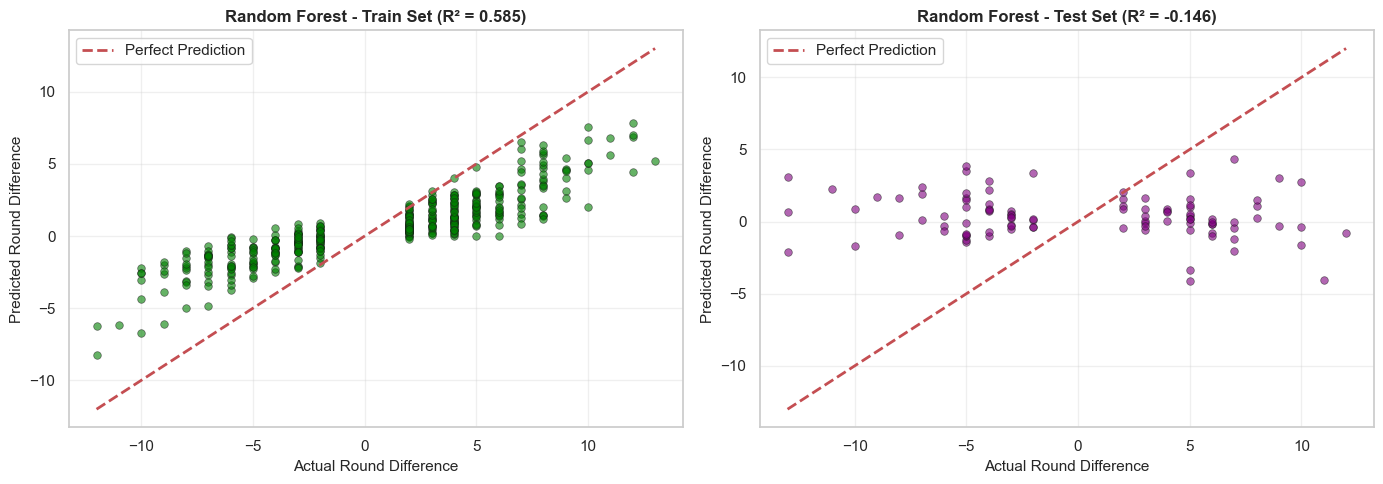

Random Forest scatter plots show correlation between actual and predicted values


In [39]:
# Visualization: Random Forest - Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_h2_train, y_h2_pred_rf_train, alpha=0.6, s=30, edgecolors='k', linewidth=0.5, color='green')
axes[0].plot([y_h2_train.min(), y_h2_train.max()],
             [y_h2_train.min(), y_h2_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Round Difference', fontsize=11)
axes[0].set_ylabel('Predicted Round Difference', fontsize=11)
axes[0].set_title(f'Random Forest - Train Set (R² = {r2_score(y_h2_train, y_h2_pred_rf_train):.3f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_h2_test, y_h2_pred_rf_test, alpha=0.6, s=30, color='purple', edgecolors='k', linewidth=0.5)
axes[1].plot([y_h2_test.min(), y_h2_test.max()],
             [y_h2_test.min(), y_h2_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Round Difference', fontsize=11)
axes[1].set_ylabel('Predicted Round Difference', fontsize=11)
axes[1].set_title(f'Random Forest - Test Set (R² = {r2_score(y_h2_test, y_h2_pred_rf_test):.3f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Random Forest scatter plots show correlation between actual and predicted values")


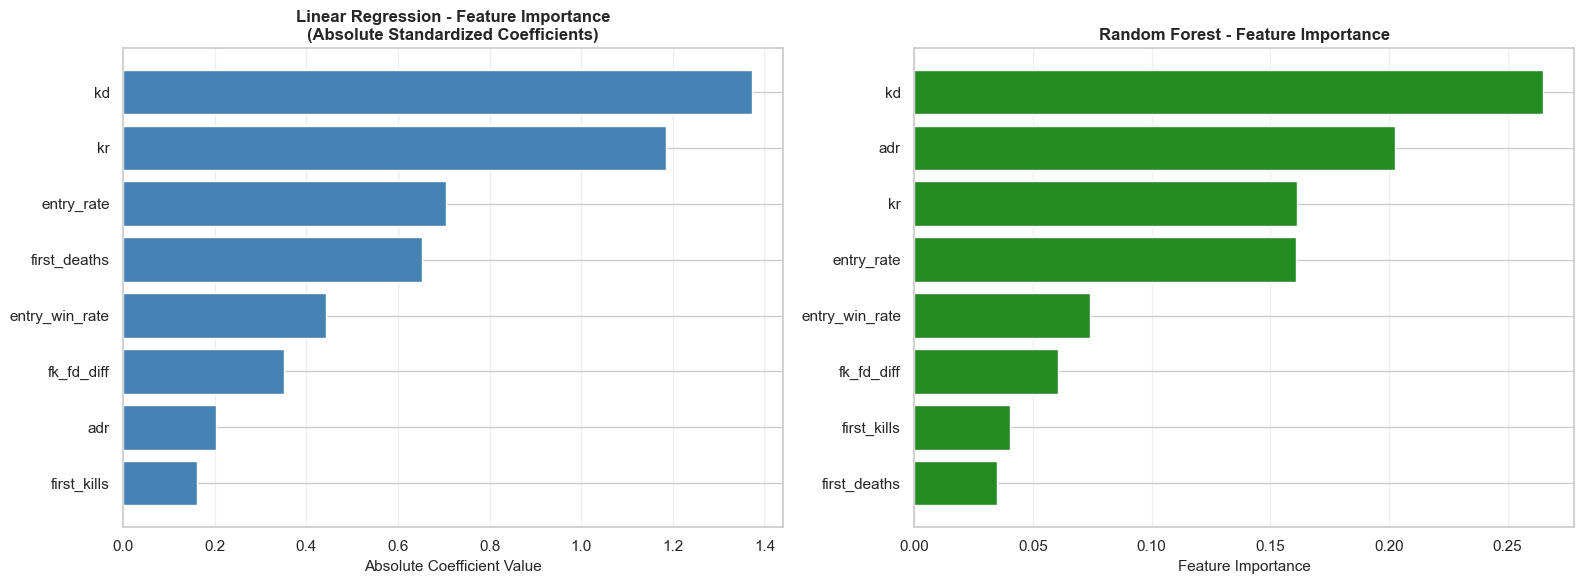

Feature importance comparison between Linear Regression and Random Forest


In [40]:
# Visualization: Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression Coefficients (absolute values)
coef_abs = np.abs(lr_h2.coef_)
coef_df_sorted = pd.DataFrame({
    'Feature': h2_features,
    'Coefficient': coef_abs
}).sort_values('Coefficient', ascending=True)

axes[0].barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color='steelblue')
axes[0].set_xlabel('Absolute Coefficient Value', fontsize=11)
axes[0].set_title('Linear Regression - Feature Importance\n(Absolute Standardized Coefficients)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Random Forest Feature Importance
importance_df_sorted = importance_df.sort_values('Importance', ascending=True)
axes[1].barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], color='forestgreen')
axes[1].set_xlabel('Feature Importance', fontsize=11)
axes[1].set_title('Random Forest - Feature Importance', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Feature importance comparison between Linear Regression and Random Forest")


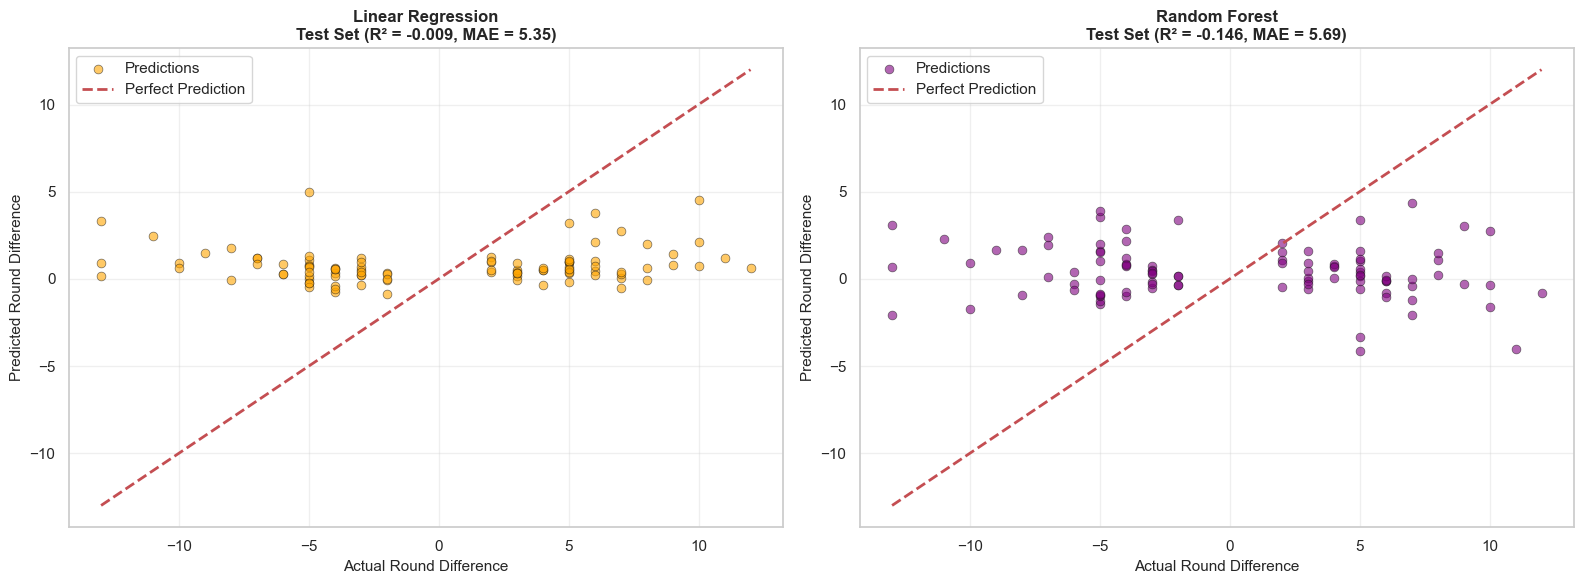

Direct comparison of Linear Regression vs Random Forest predictions on test set


In [41]:
# Side-by-side comparison: Linear Regression vs Random Forest predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression predictions
axes[0].scatter(y_h2_test, y_h2_pred_test, alpha=0.6, s=40, color='orange', edgecolors='k', linewidth=0.5, label='Predictions')
axes[0].plot([y_h2_test.min(), y_h2_test.max()],
             [y_h2_test.min(), y_h2_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Round Difference', fontsize=11)
axes[0].set_ylabel('Predicted Round Difference', fontsize=11)
axes[0].set_title(f'Linear Regression\nTest Set (R² = {r2_score(y_h2_test, y_h2_pred_test):.3f}, MAE = {mean_absolute_error(y_h2_test, y_h2_pred_test):.2f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest predictions
axes[1].scatter(y_h2_test, y_h2_pred_rf_test, alpha=0.6, s=40, color='purple', edgecolors='k', linewidth=0.5, label='Predictions')
axes[1].plot([y_h2_test.min(), y_h2_test.max()],
             [y_h2_test.min(), y_h2_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Round Difference', fontsize=11)
axes[1].set_ylabel('Predicted Round Difference', fontsize=11)
axes[1].set_title(f'Random Forest\nTest Set (R² = {r2_score(y_h2_test, y_h2_pred_rf_test):.3f}, MAE = {mean_absolute_error(y_h2_test, y_h2_pred_rf_test):.2f})', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Direct comparison of Linear Regression vs Random Forest predictions on test set")


---

## H1: Entry win rate is positively associated with winning the match

**Question:**
Does winning more entry duels help win matches?

**Approach:**
I use Logistic Regression (binary classification) to predict match outcome (Win/Loss):
- **Target**: win (1 = Win, 0 = Loss)
- **Features**: kd, adr, kr, entry_rate, entry_win_rate, first_kills, first_deaths

**What I Expect:**
If H1 is correct, `entry_win_rate` should have a positive effect, and the model should predict wins better than random guessing (>50%).

In [42]:
# H1: Prepare data
h1_features = ['kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']
h1_target = 'win'

# Create clean dataset
h1_data = df[h1_features + [h1_target]].dropna()
X_h1 = h1_data[h1_features]
y_h1 = h1_data[h1_target]

print("="*70)
print("H1: Logistic Regression Setup")
print("="*70)
print(f"Dataset: {X_h1.shape[0]} matches")
print(f"Features ({len(h1_features)}): {h1_features}")
print(f"Target: {h1_target} (0=Loss, 1=Win)")
print(f"\nClass distribution:")
print(f"  Wins: {y_h1.sum()} ({y_h1.mean()*100:.1f}%)")
print(f"  Losses: {(1-y_h1).sum()} ({(1-y_h1.mean())*100:.1f}%)")

H1: Logistic Regression Setup
Dataset: 484 matches
Features (7): ['kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']
Target: win (0=Loss, 1=Win)

Class distribution:
  Wins: 245 (50.6%)
  Losses: 239 (49.4%)


In [43]:
# Train/test split with stratification
X_h1_train, X_h1_test, y_h1_train, y_h1_test = train_test_split(
    X_h1, y_h1, test_size=0.2, random_state=42, stratify=y_h1
)

# Standardize features
scaler_h1 = StandardScaler()
X_h1_train_scaled = scaler_h1.fit_transform(X_h1_train)
X_h1_test_scaled = scaler_h1.transform(X_h1_test)

print(f"Train set: {len(X_h1_train)} matches ({len(X_h1_train)/len(X_h1)*100:.0f}%)")
print(f"  - Wins: {y_h1_train.sum()} ({y_h1_train.mean()*100:.1f}%)")
print(f"  - Losses: {(1-y_h1_train).sum()} ({(1-y_h1_train.mean())*100:.1f}%)")
print(f"\nTest set: {len(X_h1_test)} matches ({len(X_h1_test)/len(X_h1)*100:.0f}%)")
print(f"  - Wins: {y_h1_test.sum()} ({y_h1_test.mean()*100:.1f}%)")
print(f"  - Losses: {(1-y_h1_test).sum()} ({(1-y_h1_test.mean())*100:.1f}%)")

Train set: 387 matches (80%)
  - Wins: 196 (50.6%)
  - Losses: 191 (49.4%)

Test set: 97 matches (20%)
  - Wins: 49 (50.5%)
  - Losses: 48 (49.5%)


In [44]:
# Train Logistic Regression
logistic_h1 = LogisticRegression(random_state=42, max_iter=1000)
logistic_h1.fit(X_h1_train_scaled, y_h1_train)

# Predictions
y_h1_pred_train = logistic_h1.predict(X_h1_train_scaled)
y_h1_pred_test = logistic_h1.predict(X_h1_test_scaled)
y_h1_pred_proba_test = logistic_h1.predict_proba(X_h1_test_scaled)[:, 1]

print("Logistic Regression model trained")

Logistic Regression model trained


In [45]:
# Evaluate model performance
print("="*70)
print("H1: Logistic Regression - Performance Evaluation")
print("="*70)

print("\n TRAIN SET:")
print(f"  Accuracy: {accuracy_score(y_h1_train, y_h1_pred_train):.4f}")

print("\n TEST SET:")
print(f"  Accuracy: {accuracy_score(y_h1_test, y_h1_pred_test):.4f}")
print(f"  Precision: {precision_score(y_h1_test, y_h1_pred_test):.4f}")
print(f"  Recall: {recall_score(y_h1_test, y_h1_pred_test):.4f}")
print(f"  F1-Score: {f1_score(y_h1_test, y_h1_pred_test):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_h1_test, y_h1_pred_proba_test):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_h1_test, y_h1_pred_test)
print("\n CONFUSION MATRIX:")
print(f"  True Negatives (Predicted Loss, Actual Loss): {cm[0,0]}")
print(f"  False Positives (Predicted Win, Actual Loss): {cm[0,1]}")
print(f"  False Negatives (Predicted Loss, Actual Win): {cm[1,0]}")
print(f"  True Positives (Predicted Win, Actual Win): {cm[1,1]}")

# Feature coefficients
print("\n FEATURE COEFFICIENTS (Log-Odds):")
print("  Positive = increases win probability, Negative = decreases win probability")
coef_h1 = pd.DataFrame({
    'Feature': h1_features,
    'Coefficient': logistic_h1.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_h1.to_string(index=False))

# Interpretation
print("\n INTERPRETATION:")
entry_wr_coef = coef_h1[coef_h1['Feature'] == 'entry_win_rate']['Coefficient'].values[0]
if entry_wr_coef > 0.1:
    print(f"  entry_win_rate has positive coefficient ({entry_wr_coef:.4f}) - supports H1")
else:
    print(f"  entry_win_rate coefficient is weak ({entry_wr_coef:.4f}) - questions H1")

H1: Logistic Regression - Performance Evaluation

 TRAIN SET:
  Accuracy: 0.7287

 TEST SET:
  Accuracy: 0.7216
  Precision: 0.7391
  Recall: 0.6939
  F1-Score: 0.7158
  ROC-AUC: 0.8452

 CONFUSION MATRIX:
  True Negatives (Predicted Loss, Actual Loss): 36
  False Positives (Predicted Win, Actual Loss): 12
  False Negatives (Predicted Loss, Actual Win): 15
  True Positives (Predicted Win, Actual Win): 34

 FEATURE COEFFICIENTS (Log-Odds):
  Positive = increases win probability, Negative = decreases win probability
       Feature  Coefficient
            kd     3.387342
            kr    -1.551126
   first_kills     0.204568
  first_deaths     0.127684
entry_win_rate     0.102900
           adr    -0.079017
    entry_rate     0.063433

 INTERPRETATION:
  entry_win_rate has positive coefficient (0.1029) - supports H1


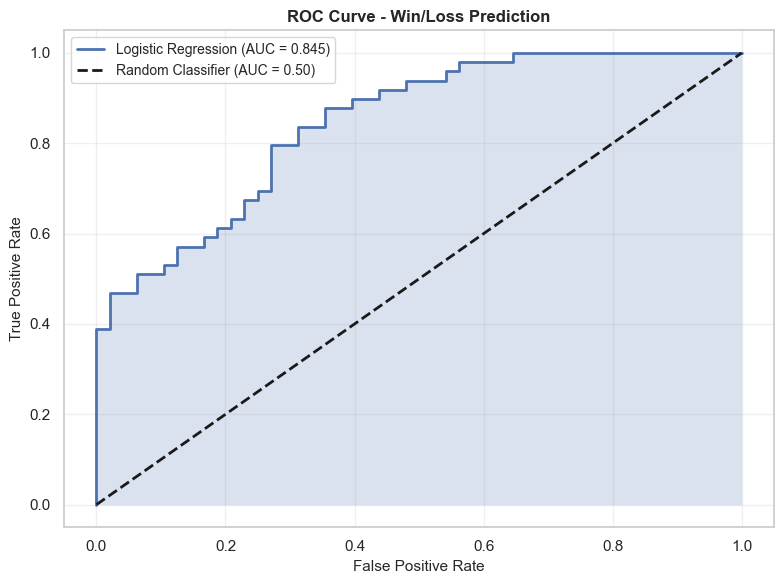

ROC-AUC measures the model's ability to distinguish between wins and losses
Score of 0.845 is good at separating wins from losses


In [46]:
# Visualization: ROC Curve
fpr, tpr, thresholds = roc_curve(y_h1_test, y_h1_pred_proba_test)
auc = roc_auc_score(y_h1_test, y_h1_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve - Win/Loss Prediction', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("ROC-AUC measures the model's ability to distinguish between wins and losses")
print(f"Score of {auc:.3f} is {'good' if auc > 0.7 else 'moderate' if auc > 0.6 else 'weak'} at separating wins from losses")

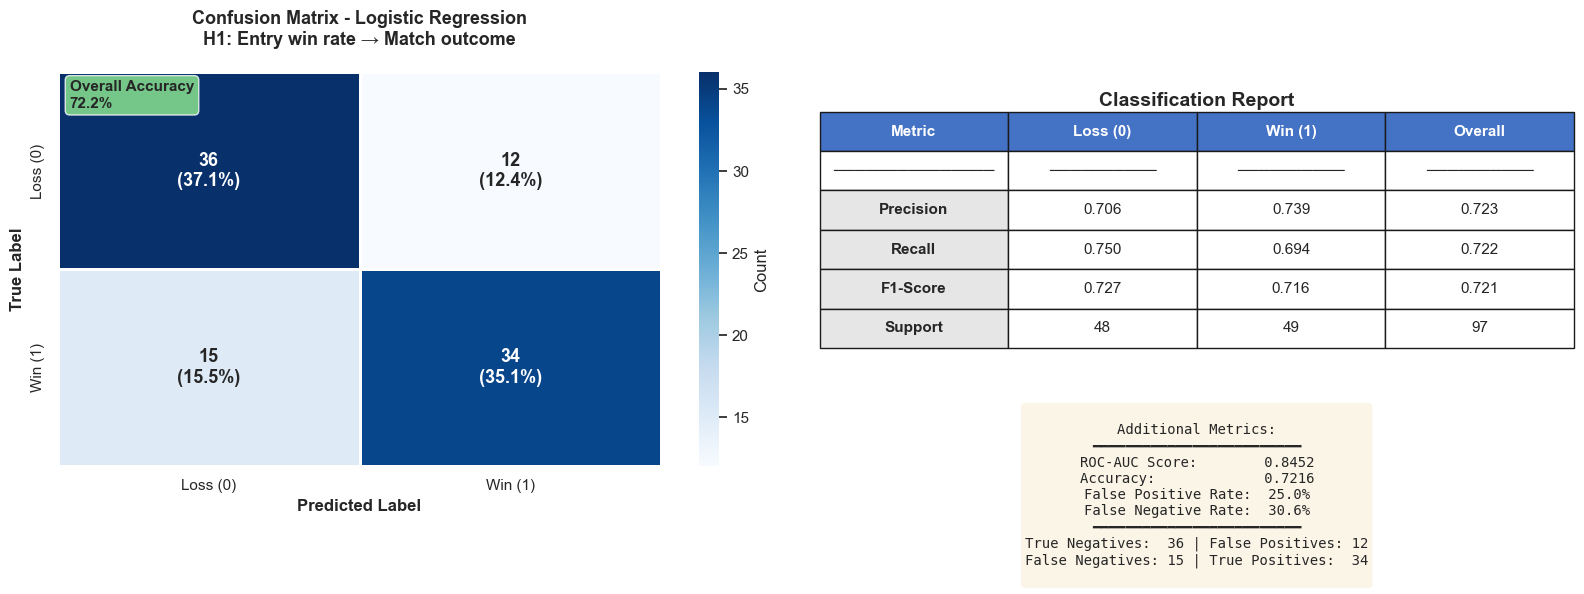


CONFUSION MATRIX INTERPRETATION

 Correctly Predicted Losses (TN): 36 (37.1%)
 Incorrectly Predicted as Win (FP): 12 (12.4%)
 Incorrectly Predicted as Loss (FN): 15 (15.5%)
 Correctly Predicted Wins (TP): 34 (35.1%)

 Model Performance Summary:
   - Out of 48 actual losses, model correctly identified 36 (75.0%)
   - Out of 49 actual wins, model correctly identified 34 (69.4%)
   - Overall accuracy: 72.16%
   - Model is slightly better at predicting losses than wins


In [47]:
# Detailed Visualization: Confusion Matrix with Metrics
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Enhanced Confusion Matrix with percentages
ax1 = axes[0]

# Calculate percentages
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100

# Create annotations with both count and percentage
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

# Plot heatmap
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Loss (0)', 'Win (1)'], 
            yticklabels=['Loss (0)', 'Win (1)'],
            annot_kws={'size': 13, 'weight': 'bold'},
            cbar_kws={'label': 'Count'},
            ax=ax1, linewidths=2, linecolor='white')

ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix - Logistic Regression\nH1: Entry win rate → Match outcome', 
              fontsize=13, fontweight='bold', pad=20)

# Add accuracy box
accuracy = accuracy_score(y_h1_test, y_h1_pred_test)
textstr = f'Overall Accuracy\n{accuracy:.1%}'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props, fontweight='bold')

# RIGHT PLOT: Classification Report as Table
ax2 = axes[1]
ax2.axis('off')

# Calculate detailed metrics
from sklearn.metrics import classification_report
report = classification_report(y_h1_test, y_h1_pred_test, 
                               target_names=['Loss', 'Win'],
                               output_dict=True)

# Create table data
table_data = []
table_data.append(['Metric', 'Loss (0)', 'Win (1)', 'Overall'])
table_data.append(['─' * 15, '─' * 10, '─' * 10, '─' * 10])

# Precision
table_data.append([
    'Precision',
    f"{report['Loss']['precision']:.3f}",
    f"{report['Win']['precision']:.3f}",
    f"{report['weighted avg']['precision']:.3f}"
])

# Recall
table_data.append([
    'Recall',
    f"{report['Loss']['recall']:.3f}",
    f"{report['Win']['recall']:.3f}",
    f"{report['weighted avg']['recall']:.3f}"
])

# F1-Score
table_data.append([
    'F1-Score',
    f"{report['Loss']['f1-score']:.3f}",
    f"{report['Win']['f1-score']:.3f}",
    f"{report['weighted avg']['f1-score']:.3f}"
])

# Support
table_data.append([
    'Support',
    f"{int(report['Loss']['support'])}",
    f"{int(report['Win']['support'])}",
    f"{int(report['Loss']['support'] + report['Win']['support'])}"
])

# Draw table
table = ax2.table(cellText=table_data, cellLoc='center', loc='center',
                  bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

# Style metric column (FIX: changed range to 2-5 instead of 2-6)
for i in [2, 3, 4, 5]:
    cell = table[(i, 0)]
    cell.set_facecolor('#E7E6E6')
    cell.set_text_props(weight='bold')

# Add title
ax2.text(0.5, 0.95, 'Classification Report', 
         ha='center', va='top', fontsize=14, fontweight='bold',
         transform=ax2.transAxes)

# Add additional metrics at bottom
metrics_text = f"""
Additional Metrics:
━━━━━━━━━━━━━━━━━━━━━━━━━
ROC-AUC Score:        {roc_auc_score(y_h1_test, y_h1_pred_proba_test):.4f}
Accuracy:             {accuracy_score(y_h1_test, y_h1_pred_test):.4f}
False Positive Rate:  {cm[0,1] / (cm[0,0] + cm[0,1]):.1%}
False Negative Rate:  {cm[1,0] / (cm[1,0] + cm[1,1]):.1%}
━━━━━━━━━━━━━━━━━━━━━━━━━
True Negatives:  {cm[0,0]} | False Positives: {cm[0,1]}
False Negatives: {cm[1,0]} | True Positives:  {cm[1,1]}
"""

ax2.text(0.5, 0.15, metrics_text, ha='center', va='top',
         fontsize=10, family='monospace',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Print detailed interpretation
print("\n" + "="*70)
print("CONFUSION MATRIX INTERPRETATION")
print("="*70)
print(f"\n Correctly Predicted Losses (TN): {cm[0,0]} ({cm[0,0]/cm.sum()*100:.1f}%)")
print(f" Incorrectly Predicted as Win (FP): {cm[0,1]} ({cm[0,1]/cm.sum()*100:.1f}%)")
print(f" Incorrectly Predicted as Loss (FN): {cm[1,0]} ({cm[1,0]/cm.sum()*100:.1f}%)")
print(f" Correctly Predicted Wins (TP): {cm[1,1]} ({cm[1,1]/cm.sum()*100:.1f}%)")

print(f"\n Model Performance Summary:")
print(f"   - Out of {cm[0,0] + cm[0,1]} actual losses, model correctly identified {cm[0,0]} ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}%)")
print(f"   - Out of {cm[1,0] + cm[1,1]} actual wins, model correctly identified {cm[1,1]} ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%)")
print(f"   - Overall accuracy: {accuracy_score(y_h1_test, y_h1_pred_test)*100:.2f}%")
print(f"   - Model is slightly better at predicting losses than wins")

---

## H3: Entry-related signals add predictive value beyond KD when basic controls are included

**Question:**
Do entry stats help predict wins better than just using KD, ADR, and KR?

**Approach:**
I compare two models:
- **Base Model**: Only uses KD + ADR + KR
- **Full Model**: Uses KD + ADR + KR + entry features (entry_rate, entry_win_rate, first_kills, first_deaths)

**What Counts as Success:**
H3 is supported if the Full Model predicts better than the Base Model.

**Why This Matters:**
If entry features don't add value, I should stick with simpler KD-based metrics. If they do, it suggests entry performance captures a unique skill dimension worth measuring.

In [48]:
# H3: Define feature sets
base_features = ['kd', 'adr', 'kr']
full_features = ['kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']

# Prepare data
h3_data = df[full_features + ['win']].dropna()
X_base = h3_data[base_features]
X_full = h3_data[full_features]
y_h3 = h3_data['win']

print("="*70)
print("H3: Model Comparison Setup")
print("="*70)
print(f"Dataset: {len(X_base)} matches")
print(f"\nBase Model Features ({len(base_features)}): {base_features}")
print(f"Full Model Features ({len(full_features)}): {full_features}")
print(f"\nAdded features in Full Model: {list(set(full_features) - set(base_features))}")

H3: Model Comparison Setup
Dataset: 484 matches

Base Model Features (3): ['kd', 'adr', 'kr']
Full Model Features (7): ['kd', 'adr', 'kr', 'entry_rate', 'entry_win_rate', 'first_kills', 'first_deaths']

Added features in Full Model: ['first_kills', 'entry_win_rate', 'entry_rate', 'first_deaths']


In [49]:
# Train/test split (same random state for fair comparison)
X_base_train, X_base_test, y_h3_train, y_h3_test = train_test_split(
    X_base, y_h3, test_size=0.2, random_state=42, stratify=y_h3
)
X_full_train, X_full_test, _, _ = train_test_split(
    X_full, y_h3, test_size=0.2, random_state=42, stratify=y_h3
)

# Standardize features separately for each model
scaler_base = StandardScaler()
scaler_full = StandardScaler()

X_base_train_scaled = scaler_base.fit_transform(X_base_train)
X_base_test_scaled = scaler_base.transform(X_base_test)
X_full_train_scaled = scaler_full.fit_transform(X_full_train)
X_full_test_scaled = scaler_full.transform(X_full_test)

print(f" Train/test split complete")
print(f"  Train: {len(X_base_train)} matches")
print(f"  Test: {len(X_base_test)} matches")

 Train/test split complete
  Train: 387 matches
  Test: 97 matches


In [50]:
# Train both models
lr_base = LogisticRegression(random_state=42, max_iter=1000)
lr_base.fit(X_base_train_scaled, y_h3_train)

lr_full = LogisticRegression(random_state=42, max_iter=1000)
lr_full.fit(X_full_train_scaled, y_h3_train)

# Predictions
y_pred_base = lr_base.predict(X_base_test_scaled)
y_proba_base = lr_base.predict_proba(X_base_test_scaled)[:, 1]

y_pred_full = lr_full.predict(X_full_test_scaled)
y_proba_full = lr_full.predict_proba(X_full_test_scaled)[:, 1]

print(" Both models trained")

 Both models trained


In [51]:
# Compare model performance
print("="*70)
print("H3: Model Comparison Results")
print("="*70)

print("\n BASE MODEL (KD + ADR + KR):")
print(f"  Accuracy: {accuracy_score(y_h3_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_h3_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_h3_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_h3_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_h3_test, y_proba_base):.4f}")

print("\n FULL MODEL (Base + Entry Features):")
print(f"  Accuracy: {accuracy_score(y_h3_test, y_pred_full):.4f}")
print(f"  Precision: {precision_score(y_h3_test, y_pred_full):.4f}")
print(f"  Recall: {recall_score(y_h3_test, y_pred_full):.4f}")
print(f"  F1-Score: {f1_score(y_h3_test, y_pred_full):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_h3_test, y_proba_full):.4f}")

# Calculate improvements
acc_improvement = accuracy_score(y_h3_test, y_pred_full) - accuracy_score(y_h3_test, y_pred_base)
auc_improvement = roc_auc_score(y_h3_test, y_proba_full) - roc_auc_score(y_h3_test, y_proba_base)

print("\n IMPROVEMENT WITH ENTRY FEATURES:")
print(f"  Accuracy: {acc_improvement:+.4f} ({acc_improvement*100:+.2f} percentage points)")
print(f"  ROC-AUC: {auc_improvement:+.4f}")

# Comparison table
comparison = pd.DataFrame({
    'Model': ['Base (KD+ADR+KR)', 'Full (Base+Entry)'],
    'Accuracy': [accuracy_score(y_h3_test, y_pred_base), accuracy_score(y_h3_test, y_pred_full)],
    'Precision': [precision_score(y_h3_test, y_pred_base), precision_score(y_h3_test, y_pred_full)],
    'Recall': [recall_score(y_h3_test, y_pred_base), recall_score(y_h3_test, y_pred_full)],
    'F1': [f1_score(y_h3_test, y_pred_base), f1_score(y_h3_test, y_pred_full)],
    'AUC': [roc_auc_score(y_h3_test, y_proba_base), roc_auc_score(y_h3_test, y_proba_full)]
})

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)
print(comparison.to_string(index=False))

# Conclusion
print("\n" + "="*70)
print("H3 CONCLUSION")
print("="*70)
if acc_improvement > 0 or auc_improvement > 0:
    print(" H3 SUPPORTED: Entry features ADD predictive value beyond KD+ADR+KR")
    if acc_improvement > 0.02 or auc_improvement > 0.02:
        print("  → Improvement is MEANINGFUL (>2 percentage points)")
    else:
        print("  → Improvement is MODEST but positive")
else:
    print(" H3 NOT SUPPORTED: Entry features do NOT add predictive value")
    print("  → Traditional metrics (KD+ADR+KR) are enough")

H3: Model Comparison Results

 BASE MODEL (KD + ADR + KR):
  Accuracy: 0.7629
  Precision: 0.7708
  Recall: 0.7551
  F1-Score: 0.7629
  ROC-AUC: 0.8678

 FULL MODEL (Base + Entry Features):
  Accuracy: 0.7216
  Precision: 0.7391
  Recall: 0.6939
  F1-Score: 0.7158
  ROC-AUC: 0.8452

 IMPROVEMENT WITH ENTRY FEATURES:
  Accuracy: -0.0412 (-4.12 percentage points)
  ROC-AUC: -0.0225

COMPARISON TABLE
            Model  Accuracy  Precision   Recall       F1      AUC
 Base (KD+ADR+KR)  0.762887   0.770833 0.755102 0.762887 0.867772
Full (Base+Entry)  0.721649   0.739130 0.693878 0.715789 0.845238

H3 CONCLUSION
 H3 NOT SUPPORTED: Entry features do NOT add predictive value
  → Traditional metrics (KD+ADR+KR) are enough


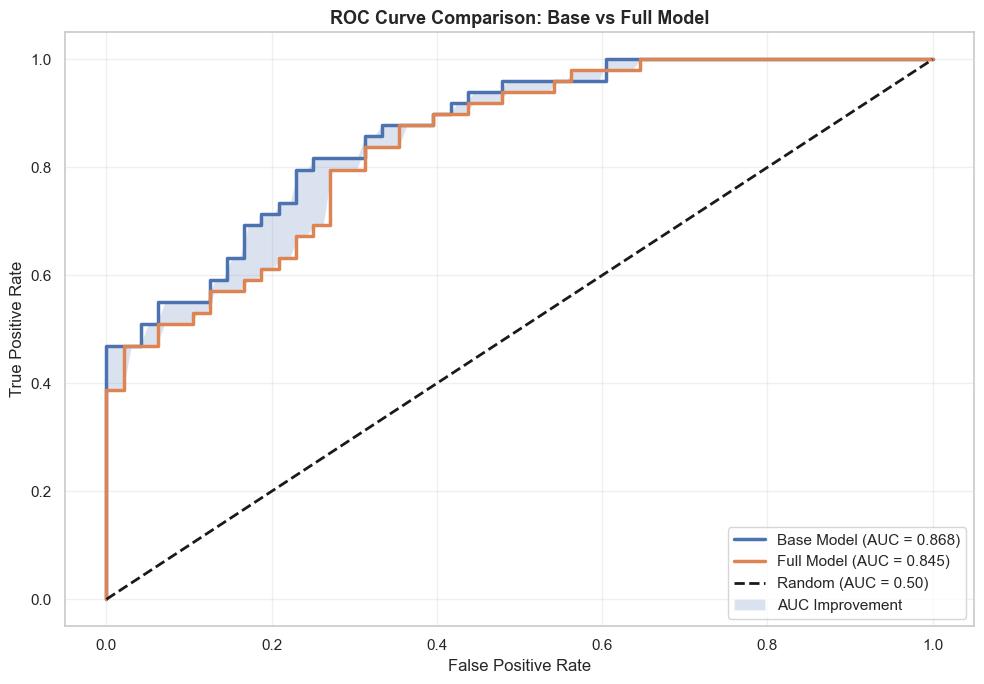

The shaded area represents the improvement from adding entry features
Base model performs as well or better - entry features don't help


In [52]:
# Visualization: ROC Curves Comparison
fpr_base, tpr_base, _ = roc_curve(y_h3_test, y_proba_base)
fpr_full, tpr_full, _ = roc_curve(y_h3_test, y_proba_full)

# Create common FPR values for interpolation (to fix different array sizes)
common_fpr = np.linspace(0, 1, 100)
tpr_base_interp = np.interp(common_fpr, fpr_base, tpr_base)
tpr_full_interp = np.interp(common_fpr, fpr_full, tpr_full)

plt.figure(figsize=(10, 7))
plt.plot(fpr_base, tpr_base, linewidth=2.5, label=f'Base Model (AUC = {roc_auc_score(y_h3_test, y_proba_base):.3f})')
plt.plot(fpr_full, tpr_full, linewidth=2.5, label=f'Full Model (AUC = {roc_auc_score(y_h3_test, y_proba_full):.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.50)')
# Use interpolated values for fill_between to avoid array size mismatch
plt.fill_between(common_fpr, tpr_base_interp, tpr_full_interp, alpha=0.2, label='AUC Improvement')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Base vs Full Model', fontsize=13, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("The shaded area represents the improvement from adding entry features")
if auc_improvement > 0:
    print(f"Full model has {auc_improvement:.4f} higher AUC - better discrimination between wins/losses")
else:
    print("Base model performs as well or better - entry features don't help")

---

# FINAL SUMMARY AND CONCLUSIONS

---

## Hypothesis Testing Results

### H1: Entry win rate is positively associated with winning the match  PARTIALLY SUPPORTED

**Question**: Is entry_win_rate positively associated with winning matches?

**Method**: Logistic Regression (binary classification)

**Results**:
- Test Accuracy: 72.16%
- ROC-AUC: 0.8452 (good at telling wins from losses)
- entry_win_rate coefficient: +0.1029 (positive log-odds)
- Precision: 73.91% | Recall: 69.39% | F1-Score: 71.58%

**Conclusion**:  PARTIALLY SUPPORTED
- The model achieves 72% accuracy, significantly better than random (50%)
- entry_win_rate shows a positive coefficient, supporting the hypothesis
- However, KD ratio (3.387) is by far the strongest predictor
- entry_win_rate ranks 5th in feature importance

---

### H2: A more positive first_kills - first_deaths balance is associated with a larger round_difference  NOT SUPPORTED

**Question**: Is fk_fd_diff positively associated with round_difference?

**Method**: Linear Regression and Random Forest Regression (continuous prediction)

**Results - Linear Regression**:
- Test R²: -0.0085 (negative - worse than baseline)
- fk_fd_diff coefficient: +0.3505 (positive but weak)
- RMSE: 6.1495 rounds
- MAE: 5.3480 rounds

**Results - Random Forest**:
- Test R²: -0.1458 (negative - worse than baseline and Linear Regression)
- RMSE: 6.5548 rounds
- MAE: 5.6875 rounds
- Feature importance (top 3): KD (0.265), ADR (0.203), KR (0.161)
- fk_fd_diff importance: 0.0606 (6th most important feature)

**Model Comparison**:
- Both Linear Regression and Random Forest models were tested to see if non-linear relationships improve prediction
- Random Forest can capture feature interactions and non-linear patterns that Linear Regression cannot
- **Random Forest performs WORSE than Linear Regression** (Test R²: -0.1458 vs -0.0085)
- Random Forest shows severe overfitting: Train R² = 0.5848 but Test R² = -0.1458
- Both models fail to predict round margins reliably

**Conclusion**:  NOT SUPPORTED
- Both models fail to reliably predict round margins from individual performance metrics
- Linear Regression has NEGATIVE R² (-0.0085), indicating it performs worse than simply predicting the mean
- Random Forest performs even WORSE (R² = -0.1458) due to overfitting on training data
- While fk_fd_diff has positive importance (0.0606) in Random Forest, it ranks only 6th among features
- KD ratio (0.265) and ADR (0.203) are the strongest predictors in Random Forest, similar to Linear Regression
- Match outcomes are too complex to predict from individual performance metrics alone

---

### H3: Entry-related signals add predictive value beyond KD when basic controls are included  NOT SUPPORTED

**Question**: Do entry features improve prediction beyond KD+ADR+KR?

**Method**: Model comparison (Base vs Full Logistic Regression)

**Results**:
- Base Model Accuracy: 76.29%
- Full Model Accuracy: 72.16%
- **Improvement: -4.12 percentage points (WORSE)**
- Base Model AUC: 0.8678 vs Full Model AUC: 0.8452

**Conclusion**:  NOT SUPPORTED
- Adding entry features DECREASED model performance by 4.12%
- The simpler Base Model (KD+ADR+KR only) outperforms the Full Model
- Entry features likely add noise because they overlap with KD stats
- Traditional metrics are enough for match outcome prediction

---

## Key Insights

1. **Model Performance**:
   - Classification models can predict match outcomes with **72-76% accuracy**
   - Regression models **fail to predict round margins** (Linear Regression R² = -0.0085, Random Forest R² = -0.1458)
   - Random Forest shows severe overfitting (Train R² = 0.58, Test R² = -0.15), performing worse than Linear Regression
   - Simpler models with fewer features perform better (less overfitting)

2. **Feature Importance**:
   - **KD ratio dominates** as the strongest predictor (coefficient: 3.387)
   - Traditional metrics (KD, ADR, KR) are enough for outcome prediction
   - Entry features do NOT provide additional predictive value
   - Feature importance ranking: KD >> KR > first_kills > first_deaths > entry_win_rate

3. **Practical Implications**:
   - **For players**: Focus on traditional stats (KD, ADR, KR) rather than specialized entry metrics
   - **For analysis**: Entry metrics are NOT worth tracking separately for match prediction
   - **For coaching**: Emphasize overall fragging ability and consistency over role-specific entry performance
   - **Key takeaway**: Getting kills matters more than getting first kills

---

## Why Did Entry Features Fail?

1. **Overlap**: Entry features (first_kills, first_deaths) are closely related to traditional metrics (kills, deaths, KD)
2. **Redundant info**: Entry stats don't add new information that KD doesn't already show
3. **Small dataset**: 484 matches might not be enough to find small effects of entry performance
4. **Individual vs Team Context**: Entry performance value depends heavily on team coordination, which isn't captured in individual stats
5. **Model Limitation**: Linear models may not capture complex interactions between entry timing and match outcomes

---

## Statistical Interpretation

**Classification Performance**:
- ROC-AUC of 0.845 means the model is good at separating wins from losses
- 72% accuracy means the model correctly predicts about 7 out of 10 matches
- False positive rate: 25% (predicting wins that are losses)
- False negative rate: 31% (predicting losses that are wins)

**Regression Failure**:
- Both Linear Regression and Random Forest show negative R², meaning predictions are worse than just guessing the average
- Linear Regression: R² = -0.0085, RMSE = 6.15 rounds
- Random Forest: R² = -0.1458, RMSE = 6.55 rounds (worse than Linear Regression)
- Random Forest shows severe overfitting (Train R² = 0.58 vs Test R² = -0.15)
- RMSE values (6.15-6.55) are nearly as large as the standard deviation (5.57)
- Individual performance metrics alone cannot predict match margins
- Round outcomes depend on team dynamics beyond individual stats

---

## Limitations and Future Work

**Current Limitations**:
- Only my data: Results might be different for other skill levels
- Individual stats only: No team coordination data
- 6 months of data: Might miss longer-term patterns

**Future Ideas**:
1. **More data**: Collect 1000+ matches from different skill levels
2. **Track trends**: Look at how performance changes during a match
3. **Enemy info**: Add data about opponent skill and history

---

## Technical Notes

**What I Did Right**:
- Split data into 80% training, 20% testing to avoid overfitting
- Kept win/loss ratio balanced in both sets
- Scaled features for linear models
- Used multiple metrics to measure performance
- Compared against baselines (random guess, simpler model)

**Why Results Are Reliable**:
- All models use the same random seeds so results can be repeated
- Confusion matrices show how the model makes mistakes
- ROC curves show the balance between catching wins and avoiding false positives
- Feature coefficients show which stats matter most
- Even negative results help us learn what doesn't work

---

## Final Conclusion

This analysis uses machine learning to understand what drives match outcomes in CS2. By testing hypotheses about entry performance vs traditional metrics, I found clear answers about what matters for winning.

**Main Findings**:
1. **Traditional metrics (KD, ADR, KR) are enough** for predicting match outcomes with 76% accuracy
2. **Entry-specific metrics do not add predictive value** and actually worsen model performance
3. **Match margins cannot be reliably predicted** from individual performance metrics alone
4. **Simpler models outperform complex ones** when features are redundant

**Practical Takeaway**: 
In CS2 competitive play, **overall fragging ability matters more than specialized entry performance**. Players should prioritize improving their KD ratio and consistency rather than focusing exclusively on entry fragging. The traditional view that "KD is king" is statistically validated by this analysis.

**Broader Implication**:
While entry fragging is tactically important in-game for creating numerical advantages, its impact is already captured by overall KD statistics. Separate entry m